In [30]:
import yfinance as yf
import pandas as pd
import os

class DataLoader:
    """lớp tải dữ liệu/ nhập dữ liệu"""
    def __init__(self, start_date=None, end_date=None):
        """
        Khởi tạo DataLoader.
        :param start_date: 'YYYY-MM-DD'
        :param end_date: 'YYYY-MM-DD'
        """
        self.start = start_date # ngày bắt đầu 
        self.end = end_date # ngày kết thúc
        self.tickers_data = {} # dict: key là tên cổ phiếu, value là dataFrame
       
    def download_data(self, tickers: list):
        print(f"Đang tải dữ liệu: {tickers}...")

        # Chuyển string đơn thành list nếu cần
        if isinstance(tickers, str):
            tickers = [tickers]

        # duyệt tải từng cổ phiếu
        for t in tickers:
            try:
                # auto_adjust=False: Giữ nguyên giá Close và Adj Close gốc
                df = yf.download(t, start=self.start, end=self.end, auto_adjust=False, progress=False)
                
                if df.empty:
                    print(f"Không có dữ liệu: {t}")
                    continue
                
                # Đảm bảo index là Datetime chuẩn
                df.index = pd.to_datetime(df.index)
                
                # Nếu yfinance trả về MultiIndex (VD: Price, Ticker) thì biến đổi thành index đơn
                if isinstance(df.columns, pd.MultiIndex):
                    df.columns = df.columns.get_level_values(0)

                # cập nhật cổ phiếu
                self.tickers_data[t] = df
                print(f"Đã tải {t}: {len(df)} dòng.")
            except Exception as e:
                print(f"Lỗi tải {t}: {str(e)}")
        
        return self.tickers_data

    def load_data(self, ticker, file_path):
        """đọc dữ liệu file từ máy, hỗ trợ đuôi csv, xlxs, xls"""
        # lấy phần mở rộng của đường dẫn 
        ext = os.path.splitext(file_path)[-1].lower() 
        try:
            if ext == ".csv":
                df = pd.read_csv(file_path, parse_dates=True, index_col=0)
            elif ext in ['.xlsx', 'xls']:
                df = pd.read_excel(file_path, parse_dates=True, index_col=0)
            else:
                raise ValueError("Unsupported format")
            self.tickers_data[ticker] = df
        except Exception as e:
            print(f"Error: {e}")

    def get_fundamental_info(self, ticker):
        """lấy thông tin của cổ phiếu"""
        try:
            t = yf.Ticker(ticker)
            return t.info
        except:
            return {}

In [31]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
import config  # Lấy tham số cấu hình (OUTLIER_THRESH)

class DataProcessor:
    """
    Class xử lý:
    1. Làm sạch (Cleaning): điền dữ liệu thiếu.
    2. Biến đổi (Transformation): Tính Log Returns (đưa về chuỗi dừng).
    3. Lọc nhiễu (Denoising): Kẹp giá trị (Winsorization).
    4. Đồng bộ (Alignment): Cắt dữ liệu theo khung thời gian chung.
    """
    def __init__(self):
        pass

    def _fill_missing_values(self, df):
        """
        - Dùng 'time' interpolation: Tốt nhất cho Time Series liên tục.
        - Dùng ffill/bfill: Để điền những chỗ khuyết của dữ liệu 
        """
        # Interpolate theo thời gian (tuyến tính)
        df = df.interpolate(method='time', limit_direction='both')
        # Fill nốt những chỗ còn lại (thường là row đầu tiên)
        df = df.ffill().bfill()
        return df

    def _compute_log_returns(self, df):
        """
        Tính Log Returns.
        Công thức: R_t = ln(P_t / P_{t-1})
        Lợi ích: Có tính cộng, phân phối gần chuẩn hơn Simple Return.
        """
        # Ưu tiên lấy Adj Close, nếu không có thì lấy Close
        price_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
        
        if price_col not in df.columns:
            return pd.DataFrame() # Trả về rỗng nếu lỗi

        df = df.copy()
        # Tính Log Return
        df['Log_Return'] = np.log(df[price_col] / df[price_col].shift(1))
        
        return df.dropna()

    def _winsorize_outliers(self, df, col_name='Log_Return', threshold=3.0):
        """
        Xử lý nhiễu bằng Z-score Clipping.
        Thay vì xóa dòng (mất dữ liệu ngày), ta kẹp giá trị về biên (Threshold).
        """
        if col_name not in df.columns:
            return df

        series = df[col_name]
        mean = series.mean()
        std = series.std()
        
        # Xác định biên trên/dưới
        upper_bound = mean + threshold * std
        lower_bound = mean - threshold * std
        
        # Kẹp giá trị (Clip)
        df[col_name] = series.clip(lower=lower_bound, upper=upper_bound)
        return df

    def _check_stationarity(self, df, col_name='Log_Return'):
        """
        Kiểm tra tính dừng (ADF Test).
        Chỉ in ra cảnh báo để User biết, không chặn luồng chạy.
        Kết quả mong đợi: chuỗi dừng vì log_return đã được diff
        """
        if col_name not in df.columns: return

        try:
            result = adfuller(df[col_name].dropna())
            p_value = result[1]
            if p_value > 0.05:
                print(f"Cảnh báo: {col_name} có thể KHÔNG DỪNG (p-value={p_value:.4f})")
        except Exception:
            pass # Bỏ qua nếu lỗi tính toán (dữ liệu quá ngắn)

    def _align_data(self, data_dict):
        """
        Đồng bộ thời gian giữa các mã.
        Chỉ giữ lại những ngày mà TẤT CẢ các mã đều có dữ liệu.
        """
        if not data_dict: return {}

        # Tìm giao (Intersection) của index
        common_index = None
        valid_tickers = []

        for ticker, df in data_dict.items():
            if df.empty: continue
            if common_index is None:
                common_index = df.index
            else:
                common_index = common_index.intersection(df.index)
            valid_tickers.append(ticker)
        
        if common_index is None or len(common_index) == 0:
            print("Lỗi: Không tìm thấy ngày giao dịch chung giữa các mã!")
            return {}

        # Cắt dữ liệu theo index chung
        aligned_dict = {}
        for t in valid_tickers:
            aligned_dict[t] = data_dict[t].loc[common_index].copy()
            
        print(f"Đã đồng bộ dữ liệu: {len(common_index)} phiên giao dịch chung.")
        return aligned_dict

    def process_all(self, raw_data_dict: dict) -> dict:
        """
        Hàm Main gọi bởi main.py.
        Pipeline: Fill NA -> Log Return -> Lọc Nhiễu -> Check Dừng -> Đồng bộ.
        """
        processed_temp = {}
        
        print("Đang xử lý dữ liệu (Cleaning & Transforming)...")

        for ticker, df in raw_data_dict.items():
            # Fill NA
            df = self._fill_missing_values(df)
            
            # Tính Log Return
            df = self._compute_log_returns(df)
            
            if not df.empty:
                # Lọc nhiễu (Outliers)
                df = self._winsorize_outliers(df, threshold=config.OUTLIER_THRESH)
                
                # Kiểm tra tính dừng (Optional check)
                self._check_stationarity(df)
                
                processed_temp[ticker] = df
        
        # Đồng bộ thời gian (Bước quan trọng nhất cho Pair Trading)
        final_data = self._align_data(processed_temp)
        
        return final_data

In [32]:
import pandas as pd
import numpy as np
import config

class MomentumIndicators:
    """
    Các chỉ báo đo sức mạnh của đà tăng/giảm.
    """
    def __init__(self):
        self.rsi_window = config.RSI_WINDOW # số ngày tính RSI

    def add_rsi(self, df):
        """
        RSI: Relative Strength Index (Chỉ số sức mạnh tương đối).
        Thang đo từ 0 đến 100.
        """
        df = df.copy()
        delta = df['Adj Close'].diff() # Giá hôm nay - Giá hôm qua
        
        # Tách khoản lãi (gain) và lỗ (loss)
        gain = (delta.where(delta > 0, 0)).rolling(window=self.rsi_window).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=self.rsi_window).mean()
        
        # Tránh lỗi chia cho 0
        loss = loss.replace(0, np.nan) 
        
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))
        
        # Fill NaN đầu tiên bằng 50 (mức trung tính)
        df['RSI'] = df['RSI'].fillna(50)
        return df

    def add_roc(self, df, periods=5):
        """
        ROC: Rate of Change (Tốc độ thay đổi giá).
        """
        df = df.copy()
        prev_price = df['Adj Close'].shift(periods)
        # Giá thay đổi bao nhiêu % so với 5 ngày trước
        df['ROC'] = ((df['Adj Close'] - prev_price) / prev_price) * 100
        return df.fillna(0)

In [33]:
import pandas as pd
import config

class TrendIndicators:
    """
    Các chỉ báo xác định xu hướng chính của dòng tiền.
    """
    def __init__(self):
        self.fast = config.MACD_FAST      # 12
        self.slow = config.MACD_SLOW      # 26
        self.signal = config.MACD_SIGNAL  # 9

    def add_sma_distance(self, df):
        """
        Khoảng cách giá so với đường trung bình (SMA).
        """
        # Copy để không ảnh hưởng dữ liệu gốc
        df = df.copy()
        
        # SMA: Giá trung bình của 20 phiên gần nhất (hoặc theo config)
        sma = df['Adj Close'].rolling(window=config.WINDOW_SIZE).mean()
        
        # Tính % lệch: Giá hiện tại đang cao hơn hay thấp hơn bao nhiêu % so với trung bình?
        df['Dist_SMA'] = (df['Adj Close'] - sma) / sma
        
        return df

    def add_macd(self, df):
        """
        MACD: Moving Average Convergence Divergence
        (Đường trung bình động hội tụ phân kỳ)
        """
        df = df.copy()
        price = df['Adj Close']
        
        # Đường nhanh (EMA 12) và Đường chậm (EMA 26)
        exp1 = price.ewm(span=self.fast, adjust=False).mean()
        exp2 = price.ewm(span=self.slow, adjust=False).mean()
        
        # Đường MACD = Nhanh - Chậm
        macd = exp1 - exp2
        
        # Đường Tín hiệu (Signal Line) = EMA 9 của đường MACD
        signal = macd.ewm(span=self.signal, adjust=False).mean()
        
        df['MACD'] = macd
        df['MACD_Signal'] = signal
        # Histogram: Khoảng cách giữa MACD và Signal (Đo độ mạnh xu hướng)
        df['MACD_Hist'] = macd - signal
        
        return df

In [34]:
import pandas as pd
import config

class VolatilityIndicators:
    """
    Các chỉ báo đo độ biến động (Rủi ro).
    """
    def __init__(self):
        self.window = config.WINDOW_SIZE
        self.num_std = config.BB_STD_DEV

    def add_bollinger_bands(self, df):
        """
        Bollinger Bands: Dải băng biến động.
        """
        df = df.copy()
        sma = df['Adj Close'].rolling(window=self.window).mean()
        std = df['Adj Close'].rolling(window=self.window).std()
        
        # Dải trên và Dải dưới
        upper_band = sma + (std * self.num_std)
        lower_band = sma - (std * self.num_std)
        
        # %B: Vị trí của giá so với 2 dải băng (0 là dải dưới, 1 là dải trên)
        # Nếu > 1: Giá vọt ra ngoài dải trên. Nếu < 0: Giá thủng dải dưới.
        bandwidth = upper_band - lower_band
        df['Boll_Percent'] = (df['Adj Close'] - lower_band) / bandwidth
        
        # Độ rộng dải băng (Bandwidth): Báo hiệu sắp có biến động lớn nếu dải băng nhỏ lại
        df['Boll_Width'] = bandwidth / sma
        
        return df

In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
from itertools import combinations
import config

class PairsIndicators:
    """
    Logic cốt lõi cho Pair Trading:
    1. Tìm cặp đồng tích hợp (Cointegration).
    2. Tính Spread và Z-score.
    """
    def __init__(self):
        pass

    def find_best_pair(self, data_dict: dict):
        """
        Quét tất cả các cặp có thể để tìm cặp di chuyển cùng nhau dài hạn
        đầu vào là dữ liệu đã được làm sạch
        """
        tickers = list(data_dict.keys())
        best_pvalue = 1.0
        best_pair = None
        
        print(f"Đang quét đồng tích hợp cho {len(tickers)} mã cổ phiếu")

        # Tạo tất cả tổ hợp cặp đôi (VD: VCB-BID, VCB-CTG...)
        for t1, t2 in combinations(tickers, 2):
            # Lấy dữ liệu giá đóng cửa đã làm sạch
            s1 = data_dict[t1]['Adj Close']
            s2 = data_dict[t2]['Adj Close']
            
            # Kiểm tra độ dài, nếu lệch nhau quá nhiều thì bỏ qua
            min_len = min(len(s1), len(s2))
            if min_len < 100: continue # Cần ít nhất 100 ngày để kiểm tra
            
            s1 = s1.iloc[-min_len:]
            s2 = s2.iloc[-min_len:]

            # KIỂM ĐỊNH COINTEGRATION (Engle-Granger Test)
            # Null Hypothesis: Không đồng tích hợp.
            # Nếu p-value < 0.05 => Bác bỏ Null => Có đồng tích hợp.
            try:
                _ , pvalue, _ = coint(s1, s2)
                if pvalue < best_pvalue:
                    best_pvalue = pvalue
                    best_pair = (t1, t2)
            except:
                continue
        
        return best_pair, best_pvalue

    def calculate_spread_zscore(self, df1, df2):
        """
        Tính Spread (Khoảng cách) và Z-score (Độ lệch chuẩn hóa).
        Công thức: Spread = Y - Beta * X
        """
        # 1. Hồi quy tuyến tính tìm Beta (Hedge Ratio)
        # Giả sử: Giá df1 = Beta * Giá df2 + E
        x = df2['Adj Close']
        y = df1['Adj Close']
        x = sm.add_constant(x) # Thêm hằng số chặn (intercept)
        
        model = sm.OLS(y, x).fit()
        beta = model.params[1] # Hệ số góc
        
        # 2. Tính Spread (Phần dư - Residual)
        # Đây chính là khoảng cách thực tế giữa 2 cổ phiếu sau khi đã cân chỉnh Beta
        spread = df1['Adj Close'] - beta * df2['Adj Close']
        
        # 3. Tính Z-score của Spread
        # Z-score cho biết Spread đang lệch bao nhiêu Sigma so với trung bình
        window = config.WINDOW_SIZE
        spread_mean = spread.rolling(window=window).mean()
        spread_std = spread.rolling(window=window).std()
        
        z_score = (spread - spread_mean) / spread_std
        
        # 4. Gộp dữ liệu lại để trả về
        # Đổi tên cột để phân biệt
        df_target = df1.add_suffix('_Y') # Mã chúng ta muốn trade chính
        df_ref = df2.add_suffix('_X')    # Mã tham chiếu
        
        df_combined = pd.concat([df_target, df_ref], axis=1)
        df_combined['Spread'] = spread
        df_combined['Spread_Z'] = z_score
        
        return df_combined.dropna(), beta

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import config

class DataHandler:
    """
    Chuẩn bị dữ liệu cho Machine Learning:
    1. Tạo Target (Mục tiêu dự báo).
    2. Chuẩn hóa (Scaling).
    3. Chia Train/Test.
    """
    def __init__(self):
        self.scaler = StandardScaler()

    def create_dataset(self, df, target_col='Spread_Z'):
        """
        Tạo bộ dữ liệu X (Đầu vào) và y (Mục tiêu).
        Mục tiêu: Dùng thông tin HÔM NAY để dự đoán Spread Z của NGÀY MAI.
        """
        df = df.copy()
        
        # Tạo cột Target 
        # Shift(-1) nghĩa là kéo giá ngày mai về dòng hôm nay.
        # Vì ta muốn máy học: "Nếu hôm nay chỉ số là A, thì ngày mai kết quả là B".
        df['Target'] = df[target_col].shift(-1)
        
        # Loại bỏ dòng cuối cùng bị NaN do shift (vì ngày mai chưa có giá)
        df = df.dropna()
        
        # Tách Features (X) và Target (y)
        # X là tất cả các cột trừ cột Target
        # (Bao gồm RSI, MACD, Spread_Z hiện tại...)
        X = df.drop(columns=['Target'])
        y = df['Target']
        
        return X, y

    def split_data(self, X, y):
        """
        Chia dữ liệu thành 2 phần: Học (Train) và Thi (Test).
        Không được tráo bài (shuffle=False) vì đây là chuỗi thời gian.
        """
        # Chia theo tỷ lệ trong config (VD: 80% đầu để học, 20% sau để kiểm tra)
        split_point = int(len(X) * config.TRAIN_SPLIT)
        
        X_train = X.iloc[:split_point]
        X_test  = X.iloc[split_point:]
        y_train = y.iloc[:split_point]
        y_test  = y.iloc[split_point:]
        
        # Chuẩn hóa dữ liệu (Scaling)
        # Giúp đưa RSI (0-100) và MACD (0.xxx) về cùng một hệ quy chiếu để Model dễ học.
        # Chỉ fit trên tập Train để tránh "nhìn trộm" dữ liệu Test (Data Leakage).
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled  = self.scaler.transform(X_test)
        
        return X_train_scaled, X_test_scaled, y_train, y_test

In [37]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

class LinearTrader:
    """
    Mô hình Hồi quy tuyến tính (Linear Regression).
    Đơn giản nhưng hiệu quả để tìm mối quan hệ tuyến tính.
    """
    def __init__(self):
        self.model = LinearRegression()

    def train(self, X_train, y_train):
        """
        Giai đoạn Học (Training):
        Máy tính tìm ra công thức y = ax + b phù hợp nhất.
        """
        self.model.fit(X_train, y_train)
        print("Mô hình đã học xong!")

    def predict(self, X_data):
        """
        Giai đoạn Dự báo:
        Đưa dữ liệu đầu vào, máy tính trả về dự đoán Spread Z ngày mai.
        """
        return self.model.predict(X_data)

    def evaluate(self, y_true, y_pred):
        """
        đánh giá mô hình.
        """
        # MSE: Sai số bình phương trung bình (Càng nhỏ càng tốt)
        mse = mean_squared_error(y_true, y_pred)
        
        # RMSE: Sai số thực tế (Cùng đơn vị với dữ liệu gốc)
        rmse = np.sqrt(mse)
        
        # R2 Score: Độ chính xác (Càng gần 1 càng tốt, âm là dự đoán bừa)
        r2 = r2_score(y_true, y_pred)
        
        print(f"Kết quả đánh giá Model:")
        print(f"- RMSE (Sai số trung bình): {rmse:.4f}")
        print(f"- R2 Score (Độ phù hợp): {r2:.4f}")
        
        return rmse, r2

In [38]:
import pandas as pd
import numpy as np
import config

class SignalLogic:
    """
    Logic sinh tín hiệu giao dịch dựa trên Z-score.
    Nguyên tắc: Mean Reversion (Đảo chiều về trung bình).
    """
    def __init__(self):
        self.entry_threshold = config.Z_ENTRY_THRESHOLD # Ngưỡng vào lệnh (2.0)
        self.exit_threshold = config.Z_EXIT_THRESHOLD   # Ngưỡng thoát lệnh (0.0)
        self.stop_loss = config.Z_STOP_LOSS             # Ngưỡng cắt lỗ (3.5)

    def generate_signals(self, df):
        """
        Input: DataFrame có cột 'Spread_Z' (Giá trị thực hoặc Dự báo).
        Output: DataFrame có thêm cột 'Signal' (1: Long, -1: Short, 0: Flat).
        """
        df = df.copy()
        
        # Tạo cột Signal mặc định là 0 (Không làm gì)
        df['Signal'] = 0
        
        # Biến trạng thái: Đang giữ lệnh gì? (0: Không, 1: Long, -1: Short)
        current_position = 0
        
        signals = []
        
        # Duyệt qua từng ngày (Loop) để giữ trạng thái lệnh (Stateful)
        # (Cách này chậm hơn vectorization nhưng dễ hiểu logic Entry/Exit hơn)
        for z_score in df['Spread_Z']:
            
            # --- TRƯỜNG HỢP 1: ĐANG CẦM TIỀN (CHƯA CÓ LỆNH) ---
            if current_position == 0:
                # Nếu Z-score thấp quá (<-2) -> Sợi thun bị nén -> MUA (Long)
                if z_score < -self.entry_threshold:
                    current_position = 1
                # Nếu Z-score cao quá (>2) -> Sợi thun bị căng -> BÁN (Short)
                elif z_score > self.entry_threshold:
                    current_position = -1
            
            # --- TRƯỜNG HỢP 2: ĐANG GIỮ LỆNH MUA (LONG) ---
            elif current_position == 1:
                # Nếu Z-score đã hồi về mức 0 (hoặc cao hơn) -> Chốt lời
                if z_score >= -self.exit_threshold:
                    current_position = 0
                # Nếu Z-score giảm sâu quá mức chịu đựng -> Cắt lỗ
                elif z_score < -self.stop_loss:
                    current_position = 0
            
            # --- TRƯỜNG HỢP 3: ĐANG GIỮ LỆNH BÁN (SHORT) ---
            elif current_position == -1:
                # Nếu Z-score đã hồi về mức 0 (hoặc thấp hơn) -> Chốt lời
                if z_score <= self.exit_threshold:
                    current_position = 0
                # Nếu Z-score tăng cao quá mức chịu đựng -> Cắt lỗ
                elif z_score > self.stop_loss:
                    current_position = 0
            
            signals.append(current_position)
            
        df['Signal'] = signals
        
        # Shift(1): Tín hiệu hôm nay dùng để vào lệnh ngày mai
        # (Để tránh nhìn thấy tương lai)
        df['Position'] = df['Signal'].shift(1).fillna(0)
        
        return df

In [39]:
import pandas as pd
import numpy as np

class Backtester:
    """
    Tính toán hiệu suất giao dịch (PnL - Profit and Loss).
    """
    def __init__(self):
        pass

    def calculate_pnl(self, df, original_spread):
        """
        Tính lãi/lỗ dựa trên tín hiệu và thay đổi của Spread.
        Input:
            df: DataFrame đã có cột 'Position' (Vị thế).
            original_spread: Series giá trị Spread gốc ($A - beta*$B).
        """
        df = df.copy()
        
        # Tính thay đổi giá của Spread hôm nay so với hôm qua
        # Spread tăng hay giảm?
        df['Spread_Change'] = original_spread - original_spread.shift(1)
        
        # Tính Lợi nhuận chiến lược
        # Lợi nhuận = Vị thế hôm qua * Mức thay đổi giá hôm nay
        # Nếu đang Long (1) và giá tăng (+) -> Lãi (+)
        # Nếu đang Short (-1) và giá giảm (-) -> Lãi (+) (Âm nhân Âm ra Dương)
        # Nếu đang Short (-1) và giá tăng (+) -> Lỗ (-)
        df['Strategy_PnL'] = df['Position'] * df['Spread_Change']
        
        # Tính tổng lãi lỗ tích lũy (Cumulative PnL)
        # Để vẽ biểu đồ tài sản tăng trưởng thế nào
        df['Cumulative_PnL'] = df['Strategy_PnL'].cumsum()
        
        return df

    def evaluate_performance(self, df):
        """
        Đánh giá các chỉ số tài chính: Sharpe Ratio, Win Rate...
        """
        # Tổng lãi/lỗ cuối cùng
        total_profit = df['Cumulative_PnL'].iloc[-1]
        
        # Số lượng lệnh (Số lần đổi trạng thái từ 0 sang khác 0)
        trades = df['Position'].diff().fillna(0).abs()
        num_trades = trades[trades > 0].count()
        
        # Sharpe Ratio (Lợi nhuận / Rủi ro)
        # Giả sử risk-free rate = 0 cho đơn giản
        daily_returns = df['Strategy_PnL']
        if daily_returns.std() == 0:
            sharpe_ratio = 0
        else:
            # Nhân căn(252) để quy đổi ra năm (năm có 252 ngày giao dịch)
            sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)
        
        print(f"KẾT QUẢ BACKTEST:")
        print(f"- Tổng Lãi/Lỗ: {total_profit:.4f} điểm Spread")
        print(f"- Số lần giao dịch: {num_trades}")
        print(f"- Sharpe Ratio: {sharpe_ratio:.2f}")
        
        if total_profit > 0:
            print("Chiến thuật CÓ LỜI")
        else:
            print("Chiến thuật THUA LỖ")
            
        return total_profit, sharpe_ratio

In [ ]:
import pandas as pd
import config

def run_system():
    print("\n" + "="*50)
    print(" HỆ THỐNG QUANT TRADING BẮT ĐẦU KHỞI ĐỘNG")
    print("="*50)

    
    # BƯỚC 1: ĐI CHỢ (Tải & Xử lý dữ liệu)
    
    print("\n[1/5] Đang tải và xử lý dữ liệu...")
    
    # 1. Tải dữ liệu thô
    loader = DataLoader(config.START_DATE, config.END_DATE)
    raw_data = loader.download_data(config.TICKERS)
    
    # 2. Làm sạch & Đồng bộ
    processor = DataProcessor()
    processed_data = processor.process_all(raw_data)
    
    print(f"   => Đã chuẩn bị xong dữ liệu sạch cho {len(processed_data)} mã.")

    
    # BƯỚC 2: SƠ CHẾ (Tính toán chỉ báo kỹ thuật)
    
    print("\n[2/5] 🛠️ Đang tính toán chỉ báo (RSI, MACD, Bollinger)...")
    
    trend = TrendIndicators()
    mom = MomentumIndicators()
    vol = VolatilityIndicators()
    
    # Lặp qua từng mã để thêm gia vị (Feature)
    for ticker, df in processed_data.items():
        # Thêm xu hướng
        df = trend.add_sma_distance(df)
        df = trend.add_macd(df)
        # Thêm sức mạnh
        df = mom.add_rsi(df)
        df = mom.add_roc(df)
        # Thêm biến động
        df = vol.add_bollinger_bands(df)
        
        # Lưu ngược lại vào dictionary (bỏ các dòng NaN do tính toán)
        processed_data[ticker] = df.dropna()
    print(processed_data[''])
    
   
if __name__ == "__main__":
    run_system()


 HỆ THỐNG QUANT TRADING BẮT ĐẦU KHỞI ĐỘNG

[1/5] Đang tải và xử lý dữ liệu...
Đang tải dữ liệu: ['VCB.VN', 'BID.VN', 'CTG.VN', 'ACB.VN', 'VIC.VN', 'VHM.VN', 'VRE.VN', 'HPG.VN', 'HSG.VN', 'NKG.VN', 'FPT.VN', 'MWG.VN', 'MSN.VN', 'VNM.VN', 'GAS.VN', 'PLX.VN']...
Đã tải VCB.VN: 1000 dòng.
Đã tải BID.VN: 1000 dòng.
Đã tải CTG.VN: 1000 dòng.
Đã tải ACB.VN: 995 dòng.
Đã tải VIC.VN: 111 dòng.
Đã tải VHM.VN: 111 dòng.
Đã tải VRE.VN: 111 dòng.
Đã tải HPG.VN: 1000 dòng.
Đã tải HSG.VN: 111 dòng.
Đã tải NKG.VN: 1000 dòng.
Đã tải FPT.VN: 1000 dòng.
Đã tải MWG.VN: 111 dòng.
Đã tải MSN.VN: 111 dòng.
Đã tải VNM.VN: 111 dòng.
Đã tải GAS.VN: 1000 dòng.
Đã tải PLX.VN: 111 dòng.
Đang xử lý dữ liệu (Cleaning & Transforming)...
Đã đồng bộ dữ liệu: 110 phiên giao dịch chung.
   => Đã chuẩn bị xong dữ liệu sạch cho 16 mã.
Đang quét đồng tích hợp cho 16 mã cổ phiếu
('MWG.VN', 'PLX.VN')


In [41]:
import pandas as pd
import config

def run_system():
    print("\n" + "="*50)
    print(" HỆ THỐNG QUANT TRADING BẮT ĐẦU KHỞI ĐỘNG")
    print("="*50)

    
    # BƯỚC 1: ĐI CHỢ (Tải & Xử lý dữ liệu)
    
    print("\n[1/5] Đang tải và xử lý dữ liệu...")
    
    # 1. Tải dữ liệu thô
    loader = DataLoader(config.START_DATE, config.END_DATE)
    raw_data = loader.download_data(config.TICKERS)
    
    # 2. Làm sạch & Đồng bộ
    processor = DataProcessor()
    processed_data = processor.process_all(raw_data)
    
    print(f"   => Đã chuẩn bị xong dữ liệu sạch cho {len(processed_data)} mã.")

    
    # BƯỚC 2: SƠ CHẾ (Tính toán chỉ báo kỹ thuật)
    
    print("\n[2/5] 🛠️ Đang tính toán chỉ báo (RSI, MACD, Bollinger)...")
    
    trend = TrendIndicators()
    mom = MomentumIndicators()
    vol = VolatilityIndicators()
    
    # Lặp qua từng mã để thêm gia vị (Feature)
    for ticker, df in processed_data.items():
        # Thêm xu hướng
        df = trend.add_sma_distance(df)
        df = trend.add_macd(df)
        # Thêm sức mạnh
        df = mom.add_rsi(df)
        df = mom.add_roc(df)
        # Thêm biến động
        df = vol.add_bollinger_bands(df)
        
        # Lưu ngược lại vào dictionary (bỏ các dòng NaN do tính toán)
        processed_data[ticker] = df.dropna()

    
    # BƯỚC 3: TÌM CẶP ĐÔI HOÀN HẢO (Pair Selection)
    
    print("\n[3/5] Đang quét tìm cặp cổ phiếu đồng tích hợp...")
    
    pairs_logic = PairsIndicators()
    best_pair, p_value = pairs_logic.find_best_pair(processed_data)
    
    if best_pair is None:
        print(" Rất tiếc! Không tìm thấy cặp nào đủ tiêu chuẩn (p-value quá cao).")
        print("   -> Thử nới lỏng COINT_PVALUE_THRESH trong config.py hoặc thêm mã khác.")
        return

    print(f"  CẶP ĐƯỢC CHỌN: {best_pair[0]} & {best_pair[1]}")
    print(f"   - Độ tin cậy (p-value): {p_value:.5f} (Càng nhỏ càng tốt)")
    
    # Tính toán Spread và Z-score cho cặp này
    df_pair, beta = pairs_logic.calculate_spread_zscore(
        processed_data[best_pair[0]], 
        processed_data[best_pair[1]]
    )
    print(f"   - Tỷ lệ Hedge (Beta): {beta:.4f}")

    
    # BƯỚC 4: HUẤN LUYỆN MÔ HÌNH (Training AI)
    
    print("\n[4/5] Đang huấn luyện mô hình dự báo Spread...")
    
    handler = DataHandler()
    
    # Tạo đề bài (X) và đáp án (y)
    # Target là 'Spread_Z' (Dự báo Z-score ngày mai)
    X, y = handler.create_dataset(df_pair, target_col='Spread_Z')
    
    # Chia tập Train/Test
    X_train, X_test, y_train, y_test = handler.split_data(X, y)
    
    # Khởi tạo và dạy Model
    model = LinearTrader()
    model.train(X_train, y_train)
    
    # Đánh giá năng lực học tập
    predictions = model.predict(X_test)
    rmse, r2 = model.evaluate(y_test, predictions)

    
    # BƯỚC 5: CHIẾN THUẬT & BACKTEST (Chạy thử nghiệm)
    
    print("\n[5/5]  Đang chạy Backtest chiến thuật Mean Reversion...")
    
    # Lấy lại DataFrame gốc tương ứng với tập Test để biết ngày tháng
    test_start_index = len(X_train)
    # Cắt lấy đoạn dữ liệu Test (phải khớp độ dài với predictions)
    df_backtest = df_pair.iloc[test_start_index : test_start_index + len(predictions)].copy()
    
    # Gán dự báo của AI vào cột 'Spread_Z' để Strategy ra quyết định
    # (Ở đây ta giả định tin tưởng hoàn toàn vào dự báo của AI)
    df_backtest['Spread_Z_Forecast'] = predictions
    
    # Sinh tín hiệu Mua/Bán dựa trên Z-score DỰ BÁO
    sig_gen = SignalLogic()
    # Ta dùng cột Forecast để ra quyết định
    df_signals = sig_gen.generate_signals(df_backtest.rename(columns={'Spread_Z_Forecast': 'Spread_Z'}))
    
    # Tính toán Lãi/Lỗ
    backtester = Backtester()
    # Cần truyền vào Spread gốc (chưa Z-score) để tính tiền thật
    original_spread_series = df_backtest['Spread']
    
    df_result = backtester.calculate_pnl(df_signals, original_spread_series)
    final_pnl, sharpe = backtester.evaluate_performance(df_result)
    
    print("\n" + "="*10)
    print("Hoàn tất")
    print("="*50)

if __name__ == "__main__":
    run_system()


 HỆ THỐNG QUANT TRADING BẮT ĐẦU KHỞI ĐỘNG

[1/5] Đang tải và xử lý dữ liệu...
Đang tải dữ liệu: ['VCB.VN', 'BID.VN', 'CTG.VN', 'ACB.VN', 'VIC.VN', 'VHM.VN', 'VRE.VN', 'HPG.VN', 'HSG.VN', 'NKG.VN', 'FPT.VN', 'MWG.VN', 'MSN.VN', 'VNM.VN', 'GAS.VN', 'PLX.VN']...
Đã tải VCB.VN: 1000 dòng.
Đã tải BID.VN: 1000 dòng.
Đã tải CTG.VN: 1000 dòng.
Đã tải ACB.VN: 995 dòng.
Đã tải VIC.VN: 111 dòng.
Đã tải VHM.VN: 111 dòng.
Đã tải VRE.VN: 111 dòng.
Đã tải HPG.VN: 1000 dòng.
Đã tải HSG.VN: 111 dòng.
Đã tải NKG.VN: 1000 dòng.
Đã tải FPT.VN: 1000 dòng.
Đã tải MWG.VN: 111 dòng.
Đã tải MSN.VN: 111 dòng.
Đã tải VNM.VN: 111 dòng.
Đã tải GAS.VN: 1000 dòng.
Đã tải PLX.VN: 111 dòng.
Đang xử lý dữ liệu (Cleaning & Transforming)...
Đã đồng bộ dữ liệu: 110 phiên giao dịch chung.
   => Đã chuẩn bị xong dữ liệu sạch cho 16 mã.

[2/5] 🛠️ Đang tính toán chỉ báo (RSI, MACD, Bollinger)...

[3/5] Đang quét tìm cặp cổ phiếu đồng tích hợp...
Đang quét đồng tích hợp cho 16 mã cổ phiếu
 Rất tiếc! Không tìm thấy cặp nào đủ 

In [18]:
dt = yf.download('ACB.VN', '2020-01-01', '2025-01-01')
dt.index

C:\Users\Giang\AppData\Local\Temp\ipykernel_19884\1697066296.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  dt = yf.download('ACB.VN', '2020-01-01', '2025-01-01')
[*********************100%***********************]  1 of 1 completed


DatetimeIndex(['2020-01-02', '2020-01-03', '2020-01-06', '2020-01-07',
               '2020-01-08', '2020-01-09', '2020-01-10', '2020-01-13',
               '2020-01-14', '2020-01-15',
               ...
               '2024-12-18', '2024-12-19', '2024-12-20', '2024-12-23',
               '2024-12-24', '2024-12-25', '2024-12-26', '2024-12-27',
               '2024-12-30', '2024-12-31'],
              dtype='datetime64[ns]', name='Date', length=1245, freq=None)

# Thu thập dữ liệu

In [5]:
FPT = StockData("FPT.VN", "2023-01-01", "2025-01-01") # khởi tạo cổ phiếu của FPT từ 1/1/2023 - 1/1/2025
data_FPT = FPT.fetch()
print(data_FPT.head(2).T)
for name, values in FPT.get_basic_info().items():
    print(f"{name}: {values}")

[*********************100%***********************]  1 of 1 completed


Date                2023-01-03    2023-01-04
Price     Ticker                            
Adj Close FPT.VN  5.042374e+04  5.042374e+04
Close     FPT.VN  5.260130e+04  5.260130e+04
High      FPT.VN  5.260130e+04  5.325882e+04
Low       FPT.VN  5.049725e+04  5.214104e+04
Open      FPT.VN  5.056300e+04  5.312731e+04
Volume    FPT.VN  2.334845e+06  1.208029e+06
Ten_cong_ty: FPT CORPORATION
Nganh: Information Technology Services
PE: 20.491802
PB: 4.7976904
EPS: 4919.04
ROE: 0.27465


### Nhận xét:
Tên công ty: FPT CORPORATION \
Tất cả chỉ số đều cao, ROE ~27%\
Công ty được kỳ vọng cao, sử dụng nguồn vốn đầu tư có hiệu quả, ổn định

# Khám phá dữ liệu

Mục đích để khám phá dữ liệu, và tránh ảnh hưởng đến dữ liệu gốc, ta tạo một dataframe copy

In [6]:
df = data_FPT.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 499 entries, 2023-01-03 to 2024-12-31
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   (Adj Close, FPT.VN)  499 non-null    float64
 1   (Close, FPT.VN)      499 non-null    float64
 2   (High, FPT.VN)       499 non-null    float64
 3   (Low, FPT.VN)        499 non-null    float64
 4   (Open, FPT.VN)       499 non-null    float64
 5   (Volume, FPT.VN)     499 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.3 KB


Dữ liệu gồm 6 cột: 
- Adj close (giá đóng điều chỉnh)
- close (giá đóng cửa)
- open (giá mở cửa)
- hight (giá cao nhất phiên)
- low (giá thấp nhất phiên)
- volume (khối lượng giao dịch)

Và 499 quan trắc, không có giá trị null

# Phân tích mối quan hệ tương quan

In [8]:
df.columns = df.columns.get_level_values(0)

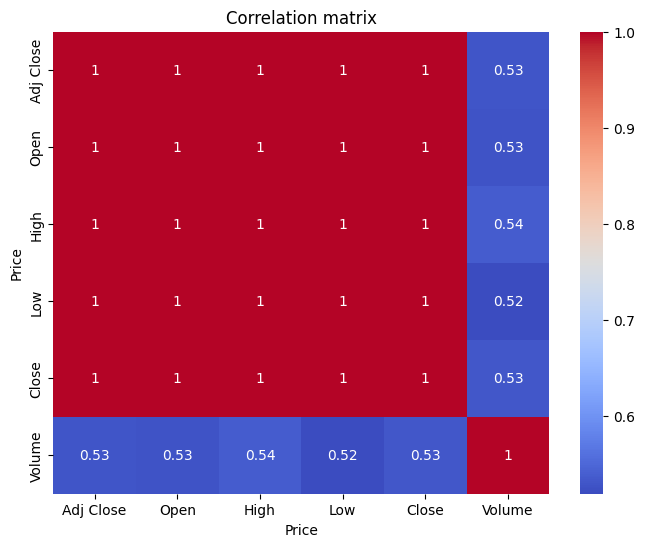

In [10]:
# heatmap 
corr = df[['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

# Phân tích dữ liệu thời gian

## Kiểm tra xu hướng

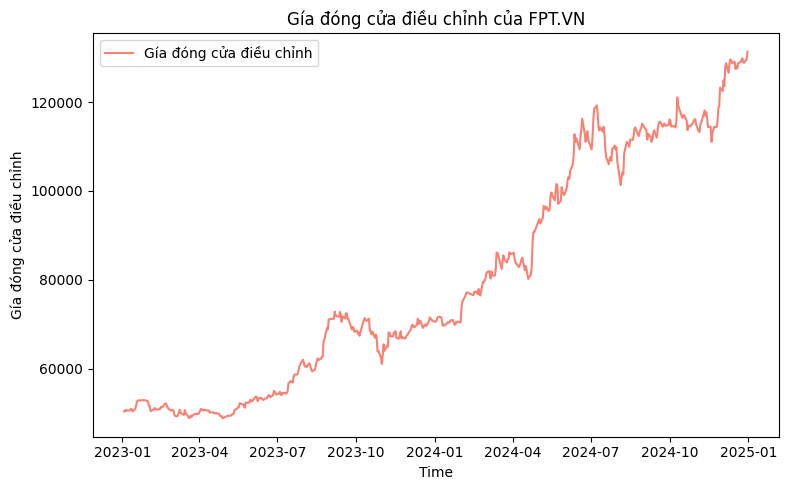

In [11]:
# Ta quan tâm đến giá đóng cửa điều chỉnh (Adj close)
adj = df['Adj Close']
plt.figure(figsize=(8,5))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh", color = 'salmon')
plt.title("Gía đóng cửa điều chỉnh của FPT.VN")
plt.xlabel("Time")
plt.ylabel("Gía đóng cửa điều chỉnh")
plt.legend()
plt.tight_layout()
plt.show()

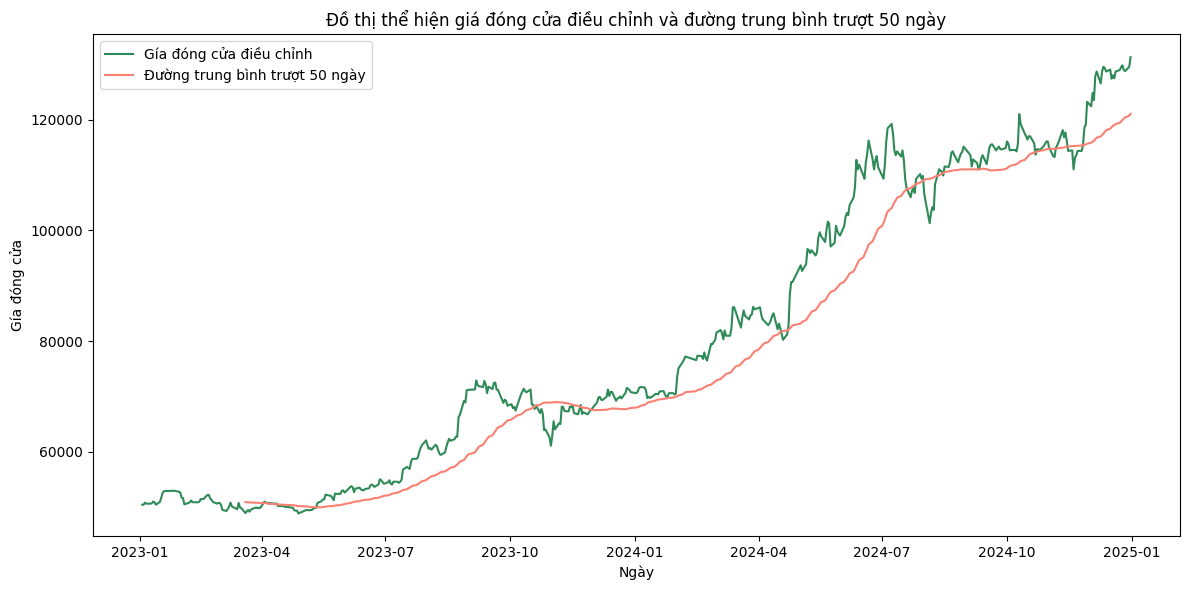

In [12]:
# dùng moving avarage để làm mượt dữ liệu để xem xu hướng 
adj = df['Adj Close']
ma_50 = adj.rolling(window=50).mean() # trung bình trượt 50 ngày 
plt.figure(figsize=(12,6))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh", color = "seagreen")
plt.plot(ma_50, label = "Đường trung bình trượt 50 ngày", color = "salmon")
plt.title("Đồ thị thể hiện giá đóng cửa điều chỉnh và đường trung bình trượt 50 ngày")
plt.xlabel("Ngày")
plt.ylabel("Gía đóng cửa")
plt.legend()
plt.tight_layout()
plt.show()

Xu hướng tăng 

## Phân rã thời gian

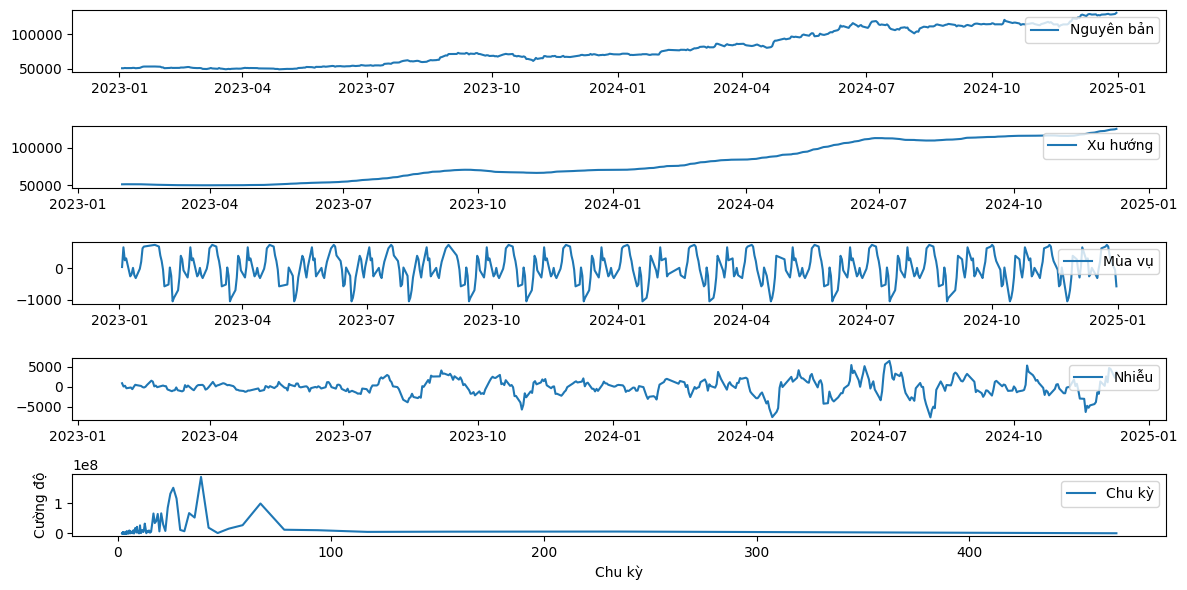

In [13]:
adj = df["Adj Close"] # cột phân tích
decomposition = seasonal_decompose(adj, model= "additive", period=30)
seasonal_val = decomposition.seasonal
trend_val = decomposition.trend
residual = decomposition.resid

# phân tích chu kỳ từ phần dư
residual_clean = residual.dropna()
# sử dụng perioddogram để phân tích chu kỳ
frequencies, power = signal.periodogram(residual_clean) 
# chuyển đổi tần số thành chu kỳ, loại bỏ tần số 0
mask = frequencies > 0
frequencies = frequencies[mask] # tần số dao động 
power = power[mask]
periods = 1 / frequencies

# vẽ các thành phần 
plt.figure(figsize=(12, 6))

# nguyên bản 
plt.subplot(5, 1, 1)
plt.plot(adj, label = "Nguyên bản")
plt.legend(loc="upper right")

# xu hướng 
plt.subplot(5, 1, 2)
plt.plot(trend_val, label = "Xu hướng")
plt.legend(loc="upper right")

# mùa vụ
plt.subplot(5, 1, 3)
plt.plot(seasonal_val, label = "Mùa vụ")
plt.legend(loc="upper right")

# Nhiễu
plt.subplot(5, 1, 4)
plt.plot(residual, label = "Nhiễu")
plt.legend(loc="upper right")

# chu kỳ
plt.subplot(5, 1, 5)
plt.plot(periods, power ,label = "Chu kỳ")
plt.xlabel("Chu kỳ")
plt.ylabel("Cường độ")
plt.legend(loc="upper right")

plt.tight_layout()
plt.show()

Xu hướng tăng\
Có tính mùa vụ

## Kiểm tra tính dừng

Một dãy thời gian được gọi là dừng nếu các đặc trưng thống kê (mean, phương sai, tự tương quan) không thay đổi theo thời gian.\
các mô hình như ARIMA, SARIMA,.. giả định đầu vào là chuỗi dừng.\
Nếu không, mô hình có thể học nhầm xu hướng thành "quy luật" => dự báo sai lệch.\
Nếu chuỗi không dừng, ta cần:
- Sai phân (differencing): trừ đi chính nó ở bước chước x[t] - x[t-1]
- Biến đổi log: giảm phương sai
- Loại bỏ xu hướng tuyến tính/ quy luật mùa vụ nếu có
- Kiểm tra tính dừng bằng ADF
+ Null Hypothesis (H0): Dãy không dừng
+ Alternative Hypothesis (H1): Dãy dừng\
Diễn giải kết quả:
- p-value < 0.05 -> bác bỏ H0 -> dãy dừng 
- p-value > 0.05 -> chấp nhận H0 -> dãy không dừng 

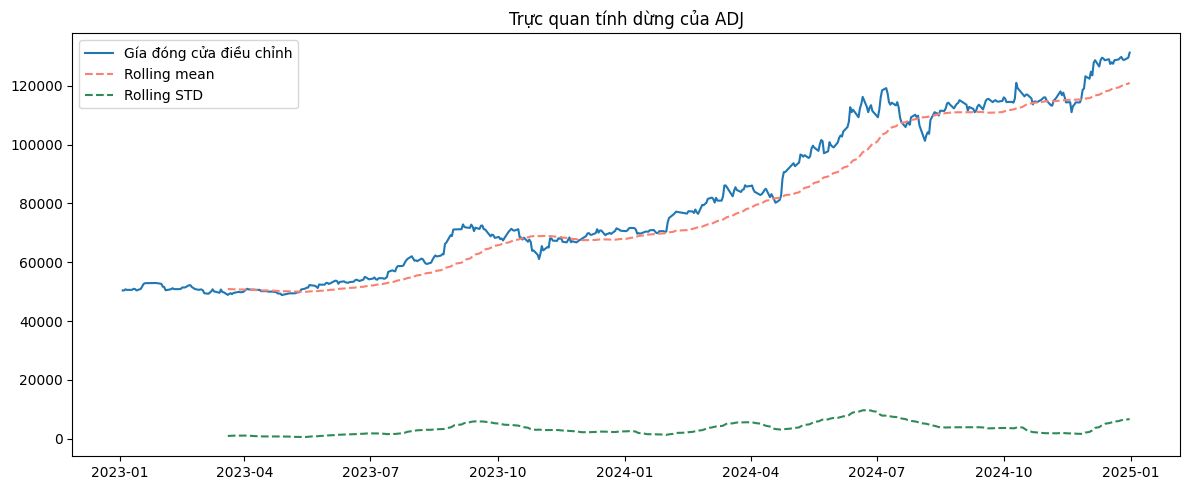

In [14]:
# kiểm tra trực quan tính dừng 
rolling_mean = adj.rolling(window=50).mean()
rolling_std = adj.rolling(window=50).std()

# trực quan 
plt.figure(figsize=(12,5))
plt.plot(adj, label = "Gía đóng cửa điều chỉnh")
plt.plot(rolling_mean, label = "Rolling mean", linestyle = '--', color = 'salmon')
plt.plot(rolling_std, label = 'Rolling STD', linestyle = '--', color = 'seagreen')
plt.title("Trực quan tính dừng của ADJ")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
# dùng kiểm định thống kê
from statsmodels.tsa.stattools import adfuller
result = adfuller(adj)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print("Chuỗi dừng")
else:
    print("Chuỗi không dừng")

ADF Statistic: 0.5099132441952842
p-value: 0.9851713072071466
Chuỗi không dừng


Điều kiện: Gỉa định chuỗi thời gian là dãy dừng
#### ACF: Hàm tự tương quan 
Đo lường mối tương quan giữa một quan sát với các giá trị trễ (độ trễ - lag) khác nhau của nó.\
VD: Gía hôm nay có liên quan gì đến giá hôm qua (lag = 1),...
#### PACF: Tự tương quan từng phần 
Cũng đô tương quan nhưng loại bỏ ảnh hưởng trung gian từ các độ trễ trước đó.\
VD: PACF tại lag = 2 đo ảnh hưởng trực tiếp từ t-2 đến t, không bị ảnh hưởng bởi t-1\
=> Ta tính toán được các hệ số của AR, MA hay ARMA,... cho huấn luyện mô hình 

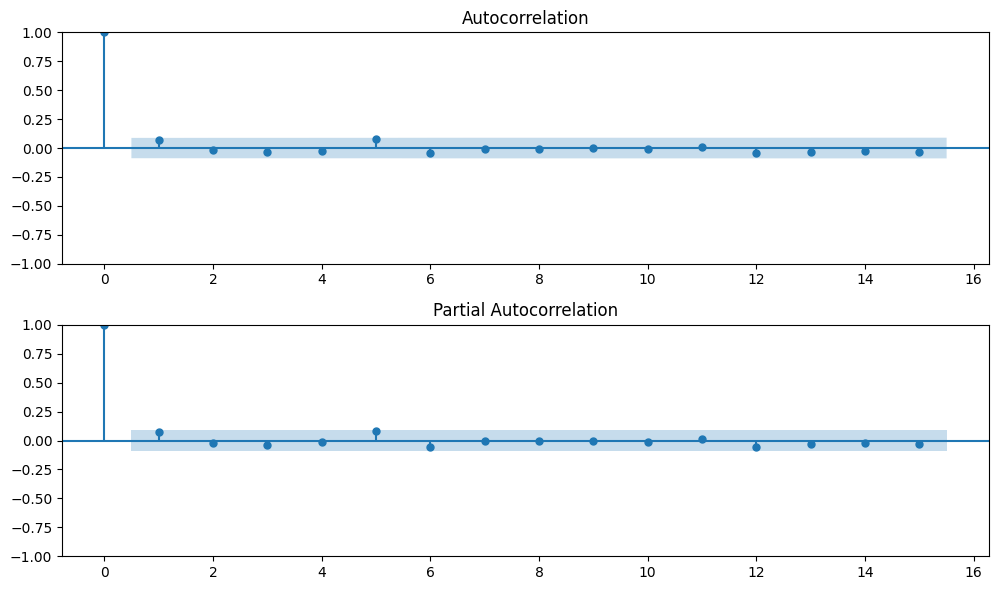

In [16]:
returns = np.log(adj / adj.shift(1)).dropna()
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(returns, lags=15, ax=ax[0])
plot_pacf(returns, lags=15, method="ols", ax=ax[1])

plt.tight_layout()
plt.show()

Dữ liệu gần như white noise => nếu train dữ liệu bằng AR/MA/ARMA thì hiệu suất sẽ không cao => không đảm bảo đúng

Tuy nhiên, ta có thể dùng volatility để đánh giá dữ liệu